# 1. 데이터셋 준비

## 1-1. 다운로드에 필요한 패키지, 라이브러리 불러오기.

In [2]:
#구글 드라이브에 있는 파일다운하기 위한 패키지
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import zipfile
import gdown
print('import OK.')


import OK.


## 1-2. 데이터 다운로드 & 경로 저장.

In [4]:
#구글드라이브에서 데이터셋 다운
import gdown

!gdown https://drive.google.com/uc?id=1rPZD1ai0A__NgulnT-mKi2tibEsddSUK 


Downloading...
From: https://drive.google.com/uc?id=1rPZD1ai0A__NgulnT-mKi2tibEsddSUK
To: /content/images.zip
100% 490M/490M [00:05<00:00, 95.7MB/s]


In [5]:
#다운받은 데이터셋 압축 풀기
import os
import zipfile

file_path = 'images.zip' #기본 경로로 다운. 실제 주소는 '/content'
zip_ref = zipfile.ZipFile(file_path, 'r') 
zip_ref.extractall('/content')
zip_ref.close()

In [6]:
#파일 경로, 파일 유형 확인하기.
import os

train_path = '/content/images/train/no_glasses'
file_list = os.listdir(train_path)
print(len(file_list))

1852


* train set의 glasses 파일: 2470
* train set의 no_glassed 파일: 1852
* test set의 파일: 각각 300개씩
* file size: 1024*1024

## 1-3. 데이터 전처리

In [7]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator


validation_ratio = 1/8  # train set 에서 train data 와 validation data를 나누는 비율.

datagen = ImageDataGenerator(validation_split=validation_ratio, rescale = 1./255)
#RGB계수 0~255 값을 0~1로 스케일링. 컬러이미지니깐 이것도 고려해야함.


# 학습용/ 검증용 데이터 분리 후 사이즈 조정.
# datagen.flow_from_directory >> 폴더명으로 라벨링을 해줍니다.

TRAINING_DIR = '/content/images/train'
train_generator = datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(256,256),  # 1024*1024 사이즈의 데이터를 256*256으로 조정.
    class_mode='categorical', 
    batch_size=100, #하이퍼파라미터, 한번 학습에 사용할 데이터의 양
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(256,256), # 1024*1024 사이즈의 데이터를 256*256으로 조정.
    class_mode='categorical', 
    batch_size=100, #하이퍼파라미터, 한번 학습에 사용할 데이터의 양
    subset='validation'
)

#테스트 데이터 생성

TEST_DIR = '/content/images/test'
datagen_test = ImageDataGenerator(rescale = 1./255) #test라서 데이터 분할 X
test_generator = datagen.flow_from_directory(
    TEST_DIR,
    target_size=(256,256),  # 1024*1024 사이즈의 데이터를 256*256으로 조정.
    class_mode='categorical', 
    batch_size=20, #하이퍼파라미터, 한번 학습에 사용할 데이터의 양
)

'''
헐 오타 한번도 안내고 한번에 출력되다니 대박
'''

Found 3781 images belonging to 2 classes.
Found 539 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


'\n헐 오타 한번도 안내고 한번에 출력되다니 대박\n'

In [15]:
#모델 미리 보기
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)      0

# 2. 모델 생성

CNN: DNN은 2차원 이미지를 그대로 flatten하여 바로 신경망에 집어넣어서 진행을 하는 반면, CNN은 이미지를 필터링하여 필터값의 feature를 도출해냄.

In [8]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

#Sequential 형식은 모델의 레이어를 한층씩 순서대로 쌓아가는 형태.
model = tf.keras.models.Sequential([
                                    
  #64개의 필터(커널) 적용.필터 사이즈가 3*3, input_shape의 3은 RGB값의 3
  tf.keras.layers.Conv2D(64,(3,3),
                         activation = 'relu',
                         input_shape = (256,256,3)),

  #MaxPooling은 (2,2)사이즈의 셀에서 max값을 대표로 풀링?
  tf.keras.layers.MaxPooling2D(2,2),

  tf.keras.layers.Conv2D(64,(3,3),
                         activation = 'relu'),
  tf.keras.layers.MaxPooling2D(2,2),

  tf.keras.layers.Conv2D(128,(3,3),
                         activation = 'relu'),
  tf.keras.layers.MaxPooling2D(2,2),

  tf.keras.layers.Conv2D(128,(3,3),
                         activation = 'relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  #이상,4차 feature까지 생성.

  #사진, 컬러값 3차원으로 되어있는 데이터를 네트워크에 집어넣기 위해1차원 배열로 flatten
  tf.keras.layers.Flatten(),

  #과적합 방지를 위한 Dropout
  tf.keras.layers.Dropout(0.5), #파라미터는 임의로 설정 가능.

  #출력 뉴런수 512개?
  tf.keras.layers.Dense(512, 
                        activation = 'relu'),
  tf.keras.layers.Dense(2, activation = 'softmax') #multi-class일때 사용. 바이너리 일때도 사용은 함.                          
])

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

#model.fit  = 학습시작 
history = model.fit(train_generator, epochs = 5,steps_per_epoch=15, validation_data = validation_generator, validation_steps=3)
# verbose : verbose : 학습 중 출력되는 문구를 설정합니다.
# 0 : 아무 것도 출력하지 않습니다.
# 1 : 훈련의 진행도를 보여주는 진행 막대를 보여줍니다.
# 2 : 미니 배치마다 손실 정보를 출력합니다.   /   출처: https://wikidocs.net/32105

Epoch 1/5
15/15 [==============================] - 337s 22s/step - loss: 0.9148 - accuracy: 0.5207 - val_loss: 0.6514 - val_accuracy: 0.5400
Epoch 2/5
15/15 [==============================] - 332s 22s/step - loss: 0.3527 - accuracy: 0.8373 - val_loss: 0.0591 - val_accuracy: 0.9833
Epoch 3/5
15/15 [==============================] - 329s 22s/step - loss: 0.0621 - accuracy: 0.9853 - val_loss: 0.0296 - val_accuracy: 0.9900
Epoch 4/5
15/15 [==============================] - 330s 22s/step - loss: 0.0922 - accuracy: 0.9858 - val_loss: 1.9763e-04 - val_accuracy: 1.0000
Epoch 5/5
15/15 [==============================] - 323s 21s/step - loss: 0.0215 - accuracy: 0.9912 - val_loss: 2.6965e-04 - val_accuracy: 1.0000


In [16]:
# 훈련된 모델을 test_generator로 평가합니다.
print("-- Evaluate(정확도) --") 
scores = model.evaluate_generator(test_generator, steps=5) 
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

-- Evaluate(정확도) --


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


accuracy: 100.00%


Saving 스크린샷 2022-07-06 오후 4.53.59.png to 스크린샷 2022-07-06 오후 4.53.59.png
[[0. 1.]]


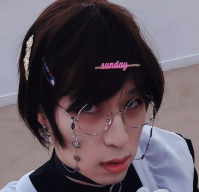

안경 쓰지 않음


In [25]:
# 훈련된 모델에 이미지를 입력하여 직접 결과를 보실 수 있습니다.

import numpy as np
from google.colab import files
from keras.preprocessing import image
from google.colab.patches import cv2_imshow
import cv2

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(256, 256))
  image_1 = cv2.imread(fn, cv2.IMREAD_REDUCED_COLOR_4)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes)
  if classes[0,0] >= 0.9:
    cv2_imshow(image_1)
    print("안경이다!")
  else:
    cv2_imshow(image_1)
    print("안경 쓰지 않음")
